# Manipulation of the non-linearity expressions found in  RF Circuits using Sympy

In [1]:
# Import some libraries for python 3.x compatibility
from __future__ import division

In this entry I explore Sympy as symbolic manipulation tool for studing the non-linear behavior of RF circuits. Sympy is a relativly new library with a nice interface but still quite some problems that some times is necesary to circunvent.  Nevertheless the clean interface and the fact that sympy is just a Python module make it a intersting module to try. More specifically I was interested to know if I could use Sympy to symbolically study the non-linear effects over the spectrum of sinousoidal inputs.

First I will take a non-linear system and calculate the output to a sinusoidal, then I will create some functios that will required to collect and classify the different harmonics at the output. Then I will calculate meticts like the 1dB compression point or the IIP3. Finally I would compare some results against the numerical solution for the 1dB compresion point.

## Harmonic distortion
A non-linear system converts sinousoid signals of a single frequency, at its input, in signals with multiple frequencies. The frequencies of the signals at the output are integer multiples of the input frequency. 
To ilustrate that suppose a memoryless system, its tranfer function can be approximated by the following function, [1]:
$$
   y(t) \approx \alpha_1 x(t) + \alpha_2 x(t)^2 + \alpha_3 x(t)^3
$$
Lets determine the response of this system to a input signal $sin(\omega t)$.

In [2]:
# Importing sympy and setting the printing in the notebook|
from sympy import symbols, init_printing
import sympy as sym
from sympy import exp, sin, cos, log, Abs, solve
from sympy.abc import c
init_printing()

In [3]:
x, t, a1, a2, a3, w, A= symbols('x, t, \\alpha_1, \\alpha_2, \\alpha_3, \\omega, A', Real=True)
y = a1 * x + a2 * x ** 2 +  a3 * x ** 3
y

the response of this system to a sinousoidal is given by:

In [4]:
y_onetone = y.subs(x, A*cos(w*t))
y_onetone

The  result given by Sympy is trivial. In order to descompose and identify the different frequency terms it necesary to reduce the power terms in the sinousoid fuctions. This task that is normally done by expanding the trigonometric functions, as the function TrigReduce function in Mathematica,  require a bit more of work in Sympy [Annex 1].  That can be achived  by rewriting the function using a exponential, then expand the resulting expression and finally collecting the cos terms. A bit complicated procedure, compared with Maxima and Sage.

In [5]:
# function to reduce the order of a expression contain terms like cos(w*t)**n
from sympy import exp, sin, cos

def expand_trig(expr):
    # exapand the complete series
    expr_int = expr.rewrite(cos, exp).rewrite(sin, exp).expand()
    # Go from exp to sin and simplify 
    expr_int = expr_int.rewrite(exp, cos).expand()
    return expr_int

y_expand = expand_trig(y_onetone)
y_expand

The different terms can be collected easily with the *collect* function:

In [6]:
harmonics = y_expand.collect([cos(w*t), cos(2*w*t), cos(3*w*t)], evaluate=False)
harmonics

The main observation here is that the gain of the circuit depends on $\alpha_1$ and also on $\alpha_3$. If  $\alpha_1\alpha_3>0$ it is said that the circuit observes a expansive behavior, meaning that the gain will increase as the input amplitude increases. On the other hand if $\alpha_1\alpha_3<0$ the circuit exhibits a compresive behavior. Although expansive behavior can be observed in electronic systems in certain limited inputs ranges, as the expansive behavior in the output current of a transistor, electronic systems are always compressive if the amplitude of the input signal is observed in a range wide enough.

## 1dB compression point
A measurment of the compression of electronics systems is the 1dB compression point. That is the point where the gain of the circuits is 1dB lower than $\alpha_1$ that is the ideal gain.

We can calculate the 1dB compression point as: 

In [7]:
Gain = (harmonics[cos(w*t)]/A).simplify()
Gain

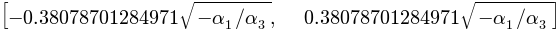

In [8]:
A1dB = solve(Gain - a1/(10**(1/20)), A)
A1dB

The two roots have meaning as the amplitude of a sinousoidal could be also a negative signal and in both cases the system will reach the 1dB compression point.  This result is well known and can be easily found in the literature, the reader cold think that it is pointless to use sympy to find it, however it is imporant to note that a similar method can be used to find the a reduce expression for the 1dB compresion point of an arbitrary system $y$.

## Intermodulation
In a similar way it is posible to find the intermodulation products of the same system. In this case the signal has to be replaced by the two tones modulation signal.

In [9]:
# Symbols for a two tones modulation 
w1, w2, A1, A2 = symbols('\\omega_1, \\omega_2, A_1, A_2', Real=True)
y_twotones = y.subs(x, A1*cos(w1*t)+A2*cos(w2*t))
y_twotones

Similarly the two tones function has to be expand with the expand_trig function that was used before, buf after expanding the function we need to convert the 

In [10]:
# The function TR8 from simplify fu returns the "sum of angles" representation
# of the terms like sin(x)*sin(y)
from sympy.simplify.fu import TR8

y_expand = expand_trig(y_twotones)
# As sum of angles
y_expand = TR8(y_expand).expand()
y_expand

those are all the terms that result of the expansion of this function, we can find easily the amplified terms, at frequencies $\omega_1, \omega_2$ and the intermodulation terms at frequencies $2\omega_1 -\omega_2, 2\omega_1 -\omega_2$

In [11]:
sel = [cos(w1*t), cos(w2*t), cos(2*w1*t-w2*t), cos(2*w2*t-w1*t)]
y_terms = y_expand.collect(sel, evaluate=False)
y_terms

Printing the only terms we are interested in:

In [12]:
y_filtered_terms = {key: y_terms[key] for key in sel}
y_filtered_terms

Lets calculate the *input third intercept point (IIP3)*, this is were the power of the ideal amplifier with gain $\alpha_1$ would intercept the power of the *interdulation products of order three (IM3)*|

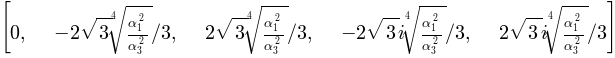

In [13]:
# Lets substitude the terms A1, A2 for A  and find the power of the signal
IM3 = ((y_filtered_terms[cos(2*w1*t-w2*t)]).subs({A2:A, A1:A}))**2
LT = (a1*A)**2

sol = solve(LT-IM3, A)
IIP3 = sol[2]
sol

The term we are intersted is the second one as is the only one positive. If we replace $\alpha_1$ and $\alpha_3$ by its absulte values, we obtain result in the most common form:

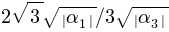

In [14]:
IIP3.subs({a1:Abs(a1), a3:Abs(a3)})

## Generalizing the 1dB and IIP3 functions

Now lets generalize this functions to find the 1dB compression point and the IIP3 for any function that can be represented by its Taylor expansion.

In [15]:
def symbolic_1dB(f_x, x, x0=0, n=6):
    '''
    Returns a symbolic expression for the 1dB compression point of the input function: f_x(x). The function is
    approximated by its taylor function around x0, with the function derivided n-times.
    '''
    A, w, t = symbols('A, \\omega, t', Positive=True)
    # Calculate the taylor expression
    f_x_taylor = sym.series(f_x, x=x, x0=x0, n=n).removeO()
    # Calculate the un-compressed gain around x0
    alpha1 = f_x_taylor.collect([x-x0], evaluate=False)[x-x0]
    # Apply the one tone test
    f_x_one_tone = f_x_taylor.subs(x, A*cos(w*t))
    # Convert to trigonometric expresions as a*cos(w*t -2*w*t)
    f_x_one_tone_expanded = expand_trig(f_x_one_tone)
    # The compressed gain is found collecting the terms
    Gain =(f_x_one_tone_expanded.collect([cos(w*t)], evaluate=False)[cos(w*t)]/A).simplify()
    # Find where the compresion gain matches the un-compressed gain -1dB
    A1dB = solve(Gain - alpha1/(10**(1/20)), A)
    for term in A1dB:
        term.simplify()
    return A1dB

def symbolic_IIP3(f_x, x, x0=0, n=6):
    '''
    Return a symbolic expression for the IM3 of a function tha represent the behavior
    the method uses a tailor expansion around x0 to obtain the IM terms'''
    A, w1, w2, t = symbols('A, \\omega1, \\omega2, t', Real=True)
    # Calculate the taylor expression
    f_x_taylor = sym.series(f_x, x=x, x0=x0, n=n).removeO()
    # Calculate un-compressed gain around x0
    alpha1 = f_x_taylor.collect([x-x0], evaluate=False)[x-x0]
    # Applie the two tones test
    f_x_two_tone = f_x_taylor.subs(x, A*cos(w1*t)+A*cos(w2*t))
    # Expand trigonometric functions
    f_x_two_tone_expanded = expand_trig(f_x_two_tone)
    # As sum of angles
    f_x_two_tone_expanded = TR8(f_x_two_tone_expanded).expand()
    # Terms that are required
    sel = [cos(w1*t), cos(w2*t), cos(2*w1*t-w2*t), cos(2*w2*t-w1*t)]
    f_x_two_tone_expanded = f_x_two_tone_expanded.collect(sel, evaluate=False)
    IM3 = (f_x_two_tone_expanded[cos(2*w1*t-w2*t)]) ** 2
    LT = (alpha1 * A) ** 2
    # solve the equation
    IIP3 = solve(LT-IM3, A)
    return IIP3

In order to verify they work we can simplly create a third order function as shown below and calculate the 1dB compression point and the IIP3. These is shown below:

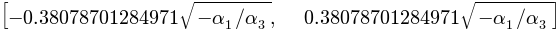

In [16]:
# Third order polynomy
y_x = a1 * x + a2 * x ** 2 +  a3 * x ** 3
A1dB_n = symbolic_1dB(y_x, x, n=6)
A1dB_n

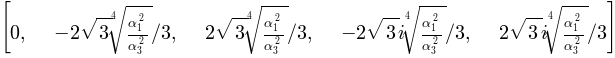

In [17]:
IIP3_n = symbolic_IIP3(y_x, x, n=6)
IIP3_n

The second root and the third, that are the both positive and real, are the ones we are looking for and the result agree with the well known expression.

## 1dB3 and IIP3 of a differential pair using MOSFET transistors
Suppose a differential cmos pair with quadratic law transistors. It can be shown that the characteristic function of this system behaves as:

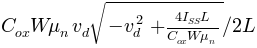

In [18]:
from sympy import sqrt, Rational
un, Cox, W, L, vd, ISS =  symbols('\\mu_n, C_{ox}, W, L , v_d, I_{SS}', positive=True)
Id  = Rational(1 / 2) * un * Cox * W / L * vd *sqrt(4 * ISS / un /Cox /(W/L) - vd**2)
Id

We can calculate the 1dB compresion point and the IIP3 easily with the functions we find above, that gives:

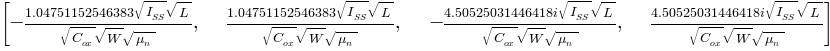

In [19]:
A1dB_n = symbolic_1dB(Id, vd, n=6)
A1dB_n

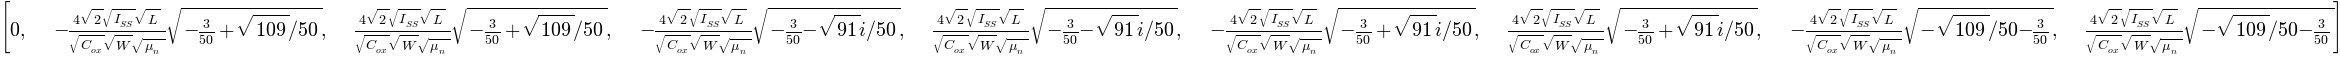

In [20]:
IIP3_n  = symbolic_IIP3(Id, vd, n=6)
IIP3_n

Selecting the roots of that make sense in both cases we have:

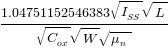

In [21]:
A1dB = A1dB_n[1]
A1dB

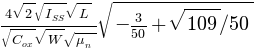

In [22]:
IIP3 = IIP3_n[2]
IIP3

We now will verify some of this results using numpy.

# Numeric verifcation

In [23]:
import sympy as sym
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Conver expresion from sympy to numpy
Id_num = sym.lambdify((un, Cox, W, L, vd, ISS), Id, modules='numpy')
A1dB_num = sym.lambdify((un, Cox, W, L, ISS), A1dB, modules='numpy')
un_val = 17.72e-3 # m**2/V*s
Cox_val = 17.26e-3  #  F/m**2
W_val = 10e-6  # m
L_val = 1e-6# m
vd_val = np.logspace(-1, -0.1, 100)
ISS_val = 1e-3
Id = Id_num(un_val, Cox_val, W_val, L_val, vd_val, ISS_val)
A1dB = A1dB_num(un_val, Cox_val, W_val, L_val, ISS_val)

In [25]:
## calculate the 1dB compresion point numerically
def find_A1dB(x, y):
    a1 = np.diff(y)/np.diff(x)
    a1 = a1[0]
    y_linear_dB = 20*np.log10(a1*x)
    ix, = np.where(y_linear_dB - 20*np.log10(y) > 1)
    return y_linear_dB, ix[0]

In [26]:
y_linear_dB, ix  = find_A1dB(vd_val, Id)

1dB  numeric 0.545(V)
1dB  sympy 0.599(V)


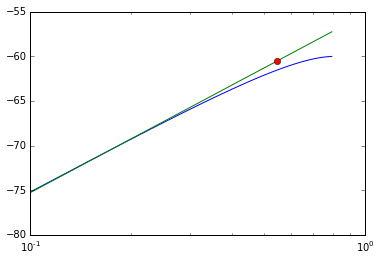

In [27]:
fig, ax = plt.subplots(1,1)
ax.semilogx(vd_val, 20*np.log10(Id), label = "non-linear")
ax.semilogx(vd_val, y_linear_dB, label = 'linear')
ax.semilogx(vd_val[ix], y_linear_dB[ix], 'o', label = '1dB')
A1dB_num  = vd_val[ix]
print("1dB  numeric {:2.3f}(V)".format(A1dB_num))
print("1dB  sympy {:2.3f}(V)".format(A1dB))

# Conclution
This entry shows how to use Sympy to calculate the 1dB and IIP3 for some aribitrary function using Sympy. 

## References
[1]B. Razavi, RF Microelectronics, 2 edition. Upper Saddle River, NJ: Prentice Hall, 2011.


## Annex 1.  Over trigonometric expansion in sympy
Sympy does not have a function to reduce the order of sinousoidals of the form $sin(x)^n$, the only functions that do something similar  is sympy.simplify.fu.TR7 but they only work for orders smaller than 3.

In [28]:
from sympy import *
def trig_expand(expr):
    return expr.rewrite(sin, exp).rewrite(cos, exp).expand().rewrite(exp, sin).simplify()

In [29]:
trig_expand(sin(x)**5)

In [30]:
trig_expand(cos(x)**5)